In [3]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import contextily as ctx
import sklearn.cluster
import numpy as np
import plotly.express as px

In [4]:
def make_geo(df: pd.DataFrame) -> geopandas.GeoDataFrame:
    """
    Convert given dataframe to geopandas.GeoDataFrame with correct coding

    :param df: pandas dataFrame containing data about car crashes
    :return: dataframe converted to GeoDataFrame
    """

    df['date'] = pd.to_datetime(df['p2a'])
    # headers = ["p1", "p36", "p37", "p2a", "weekday(p2a)", "p2b", "p6", "p7", "p8", "p9", "p10", "p11", "p12", "p13a",
    #            "p13b", "p13c", "p14", "p15", "p16", "p17", "p18", "p19", "p20", "p21", "p22", "p23", "p24", "p27",
    #            "p28",
    #            "p34", "p35", "p39", "p44", "p45a", "p47", "p48a", "p49", "p50a", "p50b", "p51", "p52", "p53", "p55a",
    #            "p57", "p58", "h", "i", "j", "k", "l", "n", "o", "p", "q", "r", "s", "t"]
    #
    # df[headers] = df[headers].astype('category')
    df = df.dropna(subset=['d','e'])
    gdf = geopandas.GeoDataFrame(df, geometry = geopandas.points_from_xy(df['d'], df['e']), crs = "EPSG:5514")
    print(gdf)
    return gdf


gdf = make_geo(pd.read_pickle("accidents.pkl.gz"))

                  p1  p36    p37         p2a  weekday(p2a)   p2b  p6  p7  p8  \
0       002100160001    4     -1  2016-01-01             5    55   1   1   0   
1       002100160002    4     -1  2016-01-01             5   130   1   3   0   
2       002100160003    5     -1  2016-01-01             5   100   1   2   0   
3       002100160004    6     -1  2016-01-01             5   120   9   0   0   
4       002100160005    6     -1  2016-01-01             5  2560   2   0   0   
...              ...  ...    ...         ...           ...   ...  ..  ..  ..   
572928  190906210456    2    210  2021-08-29             0  2115   5   0   0   
572929  190906210457    6     -1  2021-08-30             1   506   2   0   0   
572930  190906210458    6     -1  2021-08-30             1   752   2   0   0   
572932  190906210460    3   2099  2021-08-31             2  1245   0   0   0   
572933  190906210461    3  21029  2021-08-31             2  1834   3   0   4   

        p9  ...  o                     

2018
2019
2020
2021


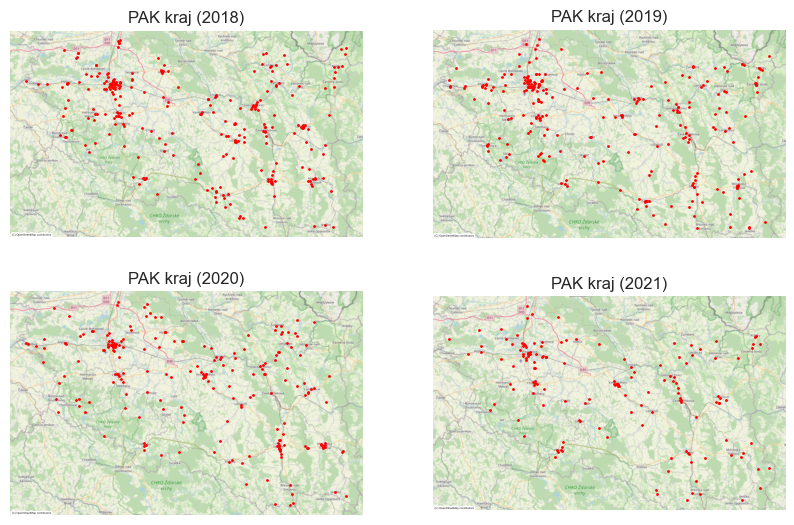

In [155]:
def plot_geo(gdf: geopandas.GeoDataFrame, fig_location: str = None, show_figure: bool = False):
    """
    Function plots map visualising car crashes that happened because of drug/alcohol use (2018-2021)

    :param gdf: GeoDataFrame with the data about crashes
    :param fig_location: path for saving generated graphs
    :param show_figure: Bool stating if user wants to show generated map
    :return: nothing (shows or saves the plot)
    """

    region_to_plot = ['PAK']
    # Filter by data by selected region and convert map's crs
    years_to_plot = [2018, 2019, 2020, 2021]
    drivers_influence_types = [3, 4, 5, 6, 7, 8, 9]
    data_to_plot = gdf[gdf['region'].isin(region_to_plot)].to_crs('EPSG:3857')
    # Filter data so that it includes only crashes where driver was under the influence
    data_to_plot = data_to_plot[data_to_plot['date'].dt.year.isin(years_to_plot) & data_to_plot['p11'].isin(drivers_influence_types)]
    fig, ax = plt.subplots(2, 2, figsize = (10, 7), gridspec_kw = {'hspace': 0, 'wspace': 0.2})

    for i, axes in enumerate(ax.reshape(-1)):
        current_year = 2018 + i
        print(current_year)
        data_to_plot_tmp = data_to_plot[data_to_plot['date'].dt.year == current_year]
        data_to_plot_tmp.plot(ax = axes, markersize = 1, color = "red")
        ctx.add_basemap(axes,
                        crs = data_to_plot_tmp.crs.to_string(),
                        source = ctx.providers.OpenStreetMap.Mapnik,
                        zoom = 10,
                        attribution_size = 2)
        # ctx.add_basemap(axes,
        #                 crs = data_to_plot_tmp.crs.to_string(),
        #                 source = ctx.providers.Stamen.TerrainLabels,
        #                 zoom = 10,
        #                 attribution_size = 2)
        axes.set_title(f"{region_to_plot[0]} kraj ({current_year})")
        axes.set_axis_off()

    #fig.tight_layout()
    #fig.subplots_adjust(hspace = 0.1, wspace = 0.2)


    if fig_location:
        plt.savefig(fig_location, dpi = 300)
    if show_figure:
        plt.show()
    plt.close()

plot_geo(gdf, "geo1.png", True)

C:\FITVUT\PART3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


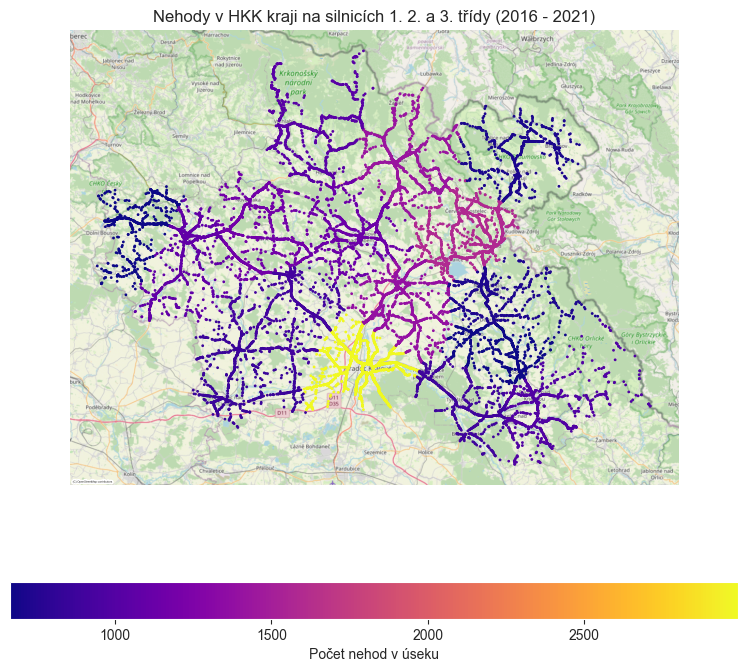

In [151]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans


def plot_cluster(gdf: geopandas.GeoDataFrame, fig_location: str = None, show_figure: bool = False):
    """
    Function plots map visualising cluster of car crashes

    :param gdf: GeoDataFrame with the data about crashes
    :param fig_location: path for saving generated graphs
    :param show_figure: Bool stating if user wants to show generated map
    :return: nothing (shows or saves the plot)
    """

    region_to_plot = ['PAK']
    wanted_road_types = [1, 2, 3]
    # Filtering our data to contain only wanted region and road type
    data_to_plot = gdf[gdf['region'].isin(region_to_plot) & gdf['p36'].isin(wanted_road_types)].to_crs('EPSG:3857')

    # Getting crash points and reshaping them to correct shape
    x = data_to_plot.geometry.x
    y = data_to_plot.geometry.y
    points = np.dstack([x, y]).reshape(-1, 2)

    data_to_plot['clusters'] = MiniBatchKMeans(n_clusters = 16).fit(points).labels_
    data_to_plot = data_to_plot.dissolve(by = "clusters", aggfunc = {"p1": "count"})


    # Plotting the map
    fig, ax = plt.subplots(1, 1, figsize = (10, 7))
    data_to_plot.plot(ax = ax,
                      markersize = 1,
                      column = 'p1',
                      legend = True,
                      legend_kwds={'label': "Počet nehod v úseku", 'orientation': "horizontal", 'shrink': 0.75, 'anchor': (0.5, 1)},
                      cmap='plasma')
    ctx.add_basemap(ax,
                    crs = data_to_plot.crs.to_string(),
                    source = ctx.providers.OpenStreetMap.Mapnik,
                    zoom = 10,
                    attribution_size = 2)
    ax.set_title(f'Nehody v {region_to_plot[0]} kraji na silnicích 1. 2. a 3. třídy (2016 - 2021)')
    ax.set_axis_off()
    plt.tight_layout()

    if fig_location:
        plt.savefig(fig_location, dpi = 300)
    if show_figure:
        plt.show()
    plt.close()

plot_cluster(gdf, "geo2.png", True)